# **Extended Project 2: Linear Classification**

Courses: Computation Machine Learning I and Computing for Data Science \\
Submitted: Nov 28, 2021 \\
Student: Mathias Schindler


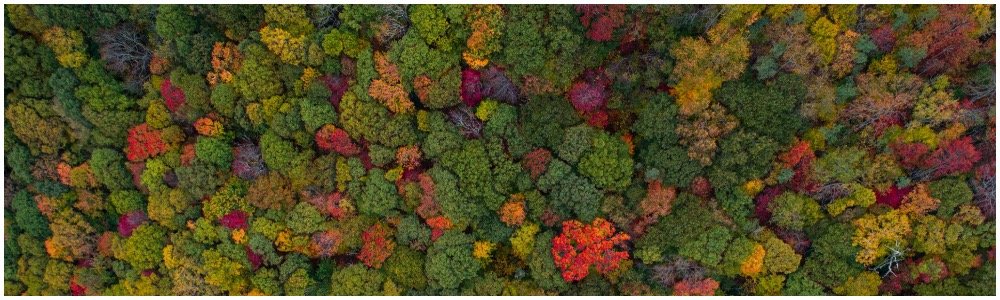

# Instructions

## Programming project: forest cover classification

In this project, you have to predict the class of forest cover (the predominant kind of tree cover) from strictly cartographic and environment variables.

The actual forest cover type for a given observation (30 x 30 meter cell) was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data. Data is in raw form (not scaled) and contains categorical data for qualitative independent variables (wilderness areas and soil types).

You have further details on the data at *covertype.info* file and at https://archive.ics.uci.edu/ml/datasets/Covertype

Be aware that the final dataset has been slighly modified from the original source data.

As performance metric, you can use *AUC* in the binary classification case. For multi-class classification, check as well the confussion matrix and estimate the misclassification probabilities of different classes(check *metrics.confusion_matrix* and *metrics.classification_report* in *sklearn*).

+ Using *MultiClass_Train.csv* file build a predictive model for *Cover_Type* .
+ Try a first a binary classification to predict class #7 (Krummholz, https://en.wikipedia.org/wiki/Krummholz), which is a rare valuable habitat. After that, then try multi-variate classification to predict all classes.
+ For this analysis there is an extra test dataset. Once your code is submitted we will run a competition to see how you score in the test data. Hence have prepared also the necessary script to compute the accuracy estimate on the test data once released.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Create *dummy variables* for relevant categorical features
3. Reformat the Class_type variable into a binary one, being class #7 the target variable versus the others.
4. *Build* an initial binary model for class #7 versus the other ones and test it on the same input data. 
5. Assess expected accuracy using *cross-validation*
6. Report which variable impacts more on results 
7. Try to improve it using methods to tackle class imbalance.
8. Repeat 4., 5., 6. and 7. now with a multi-class model (EXTENDED PROJECT)
9. Produce .csv for kaggle testing 


## Main criteria for grading
From more to less important (the weighting of these components will vary between the in-class and extended projects):
+ Code runs
+ Data preparation
+ Logistic Regression Models(s) have been used
+ Cover Type prediction made
+ Accuracy of predictions for test set (kaggle)
+ Class imbalance management
+ Hyperparameter optimization

# **0. Load Libraries and Data**

In [ ]:
# clear all
%reset -f

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
os.chdir('/content/drive/My Drive/CML1_Projects/Project2_LinearClassification')

Mounted at /content/drive


In [ ]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#from sklearn import metrics
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import PolynomialFeatures as plf
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.pipeline import Pipeline
from sklearn import decomposition
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE

Custom functions:

In [ ]:
# Set print options (show narrays as decimals, not scientific)
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

In [ ]:
import schindler_project2_functions as my_fcts
dir(my_fcts)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'make_feat_importance_plot',
 'make_multi_point_pred',
 'make_roc_plot',
 'make_scree_plot',
 'np',
 'pd',
 'plot_confusion_matrix',
 'plt',
 'reweight',
 'reweight_proba_multi',
 'sns']

# **1. Exploratory Data Analysis**

In [ ]:
# Read  data
df_train = pd.read_csv('Data/MultiClass_Train.csv', index_col = 0)
df_test = pd.read_csv('Data/MultiClass_Test.csv', index_col = 0)

print(df_train.columns)
print(df_test.columns)

Index(['Elevation', 'Aspect', 'Slope', 'Horiz_dist_hydro',
       'Vertical_dist_hydro', 'Horiz_dist_roadways', 'Hillshade_9am',
       'Hillshade_Noon', 'Hillshade_3pm', 'Horiz_dist_firepoints',
       'Cover_Type', 'Wilderness_Area', 'Soil_Type'],
      dtype='object')
Index(['Elevation', 'Aspect', 'Slope', 'Horiz_dist_hydro',
       'Vertical_dist_hydro', 'Horiz_dist_roadways', 'Hillshade_9am',
       'Hillshade_Noon', 'Hillshade_3pm', 'Horiz_dist_firepoints',
       'Wilderness_Area', 'Soil_Type'],
      dtype='object')


In [ ]:
# Column(s) in train but not in test dataset
df_train.columns.difference(df_test.columns)

Index(['Cover_Type'], dtype='object')

In [ ]:
# Inspect value counts of target variable
df_train['Cover_Type'].value_counts()

2    29690
1    22199
3     3802
7     2163
6     1865
5      992
4      295
Name: Cover_Type, dtype: int64

1         AxesSubplot(0.1,0.559091;0.173913x0.340909)
2    AxesSubplot(0.308696,0.559091;0.173913x0.340909)
3    AxesSubplot(0.517391,0.559091;0.173913x0.340909)
4    AxesSubplot(0.726087,0.559091;0.173913x0.340909)
5             AxesSubplot(0.1,0.15;0.173913x0.340909)
6        AxesSubplot(0.308696,0.15;0.173913x0.340909)
7        AxesSubplot(0.517391,0.15;0.173913x0.340909)
dtype: object

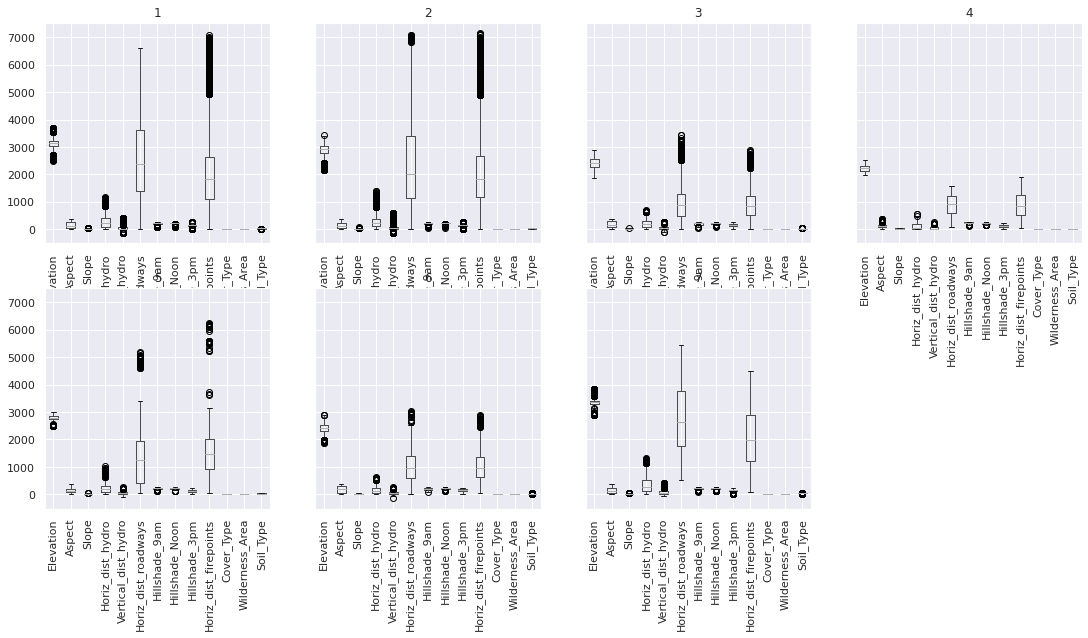

In [ ]:
# Check distribution of predictors
df_train.groupby('Cover_Type').boxplot(rot=90, figsize = [18,9], layout = (2, 4) )

There seems to be variation in the distribution of featuers for different categories of $Cover\_Type$.

In [ ]:
#Check for missing values
print(df_train.isnull().any())
print("\n")
print(df_test.isnull().any())

Elevation                False
Aspect                   False
Slope                    False
Horiz_dist_hydro         False
Vertical_dist_hydro      False
Horiz_dist_roadways      False
Hillshade_9am            False
Hillshade_Noon           False
Hillshade_3pm            False
Horiz_dist_firepoints    False
Cover_Type               False
Wilderness_Area          False
Soil_Type                False
dtype: bool


Elevation                False
Aspect                   False
Slope                    False
Horiz_dist_hydro         False
Vertical_dist_hydro      False
Horiz_dist_roadways      False
Hillshade_9am            False
Hillshade_Noon           False
Hillshade_3pm            False
Horiz_dist_firepoints    False
Wilderness_Area          False
Soil_Type                False
dtype: bool


I will also inspect a heatmap with correlations between the features.

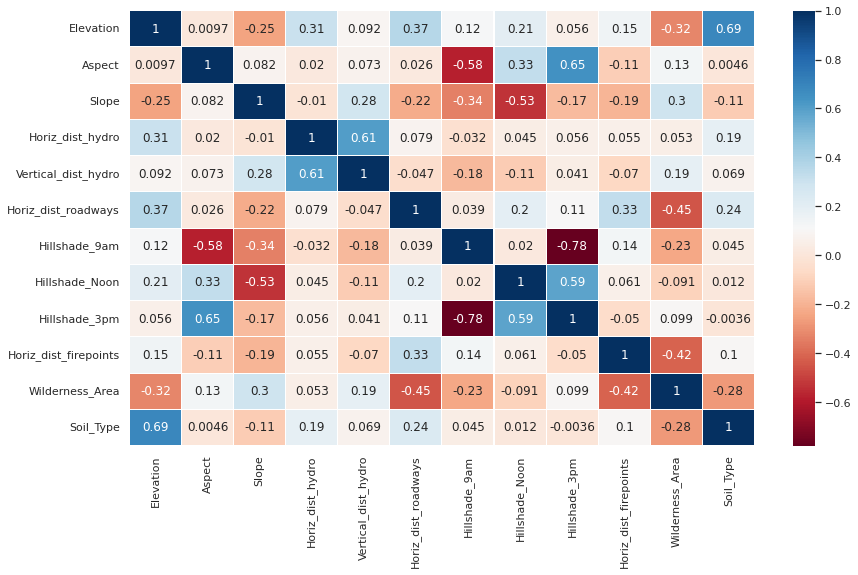

In [ ]:
# plot the heatmap
colormap = plt.cm.RdBu

sns.heatmap(df_train.corr(), linewidths=0.1, 
            square=False, cmap=colormap, linecolor='white', annot=True)
fig = plt.gcf()
fig.set_size_inches(14, 8)

# **2. Preprocessing Data**

## 2.1 Set Target Variable

Creating binary target variable for binary models. Class 7 is the target to predict. Also creating a copy for the multiclass model.

In [ ]:
# Binary target variable
target_bin = [1 if q == 7 else 0 for q in df_train['Cover_Type'] ]
print(target_bin.count(0))
print(target_bin.count(1))

58843
2163


So we seem to have class imbalance as only roughly 3.5% are class #7.

In [ ]:
# Multiclass target variable
target_multi = df_train['Cover_Type'].copy()
target_multi.value_counts()

2    29690
1    22199
3     3802
7     2163
6     1865
5      992
4      295
Name: Cover_Type, dtype: int64

In [ ]:
# Remove target from training data set
df_train = df_train.drop('Cover_Type', axis = 1)

## 2.2 Divide Continuous and Categorical Features

In [ ]:
cat_feats = ['Soil_Type', 'Wilderness_Area']

# Data sets with continuous feats
df_train_cont, df_test_cont = df_train.drop(cat_feats, axis = 1), df_test.drop(cat_feats, axis = 1)

#Data sets with categorical feats
df_train_cat, df_test_cat = df_train[cat_feats], df_test[cat_feats]

## 2.3 Transform Categorical Features

I simply create dummies for the categorical features `Wilderness_Area` and `Soil_Type`.

In [ ]:
col_list = ['Wilderness_Area', 'Soil_Type']
prfx_dict = {'Wilderness_Area': 'wild_area', 'Soil_Type': 'soil_'}

# Train data
df_train_dumm = pd.get_dummies(df_train_cat, prefix=prfx_dict, columns=col_list, drop_first = True)

# Test data
df_test_dumm = pd.get_dummies(df_test_cat, prefix=prfx_dict, columns=col_list, drop_first = True)

## 2.4 Transform Continuous Features

### 2.4.1 Polynomial Transformation

In [ ]:
%%capture 

# Set degree 
degree = 2

# Instantiate
poly = plf(degree, include_bias = False)

# Fit 
poly.fit(df_train_cont)

# Get column names
poly_col_names = poly.get_feature_names(df_train_cont.columns) 

# Transform data
df_train_poly, df_test_poly = poly.transform(df_train_cont), poly.transform(df_test_cont)

# Dataframes
df_train_poly = pd.DataFrame(df_train_poly, columns = poly_col_names, index = df_train_cont.index)
df_test_poly = pd.DataFrame(df_test_poly, columns = poly_col_names, index = df_test_cont.index)

In [ ]:
df_train_poly.columns.difference(df_test_poly.columns) #No difference

Index([], dtype='object')

### 2.4.2 Standardize Continuous Features

Because regression models are run with a penalty term the data should be standardized in order for the penalty to be equivalent across features with different scales

In [ ]:
# Instantiate
scaler = StandardScaler()

# Fit
scaler.fit(df_train_poly)

# Transform
df_train_poly_scl, df_test_poly_scl = scaler.transform(df_train_poly), scaler.transform(df_test_poly)

# Dataframes
df_train_poly_scl = pd.DataFrame(df_train_poly_scl, columns = df_train_poly.columns, index = df_train_poly.index)
df_test_poly_scl = pd.DataFrame(df_test_poly_scl, columns = df_test_poly.columns, index = df_test_poly.index)

## 2.5 Concatenate Continuous and Categorical Transformed Features

In [ ]:
df_train_for_reg = pd.concat([df_train_dumm, df_train_poly_scl], axis = 1)
df_test_for_predict = pd.concat([df_test_dumm, df_test_poly_scl], axis = 1)

## 2.6 Dimensionality Reduction 

To ease computational expense of calculations dimensionality is reduced by applying PCA. Running the models on the full dataset (polynomials, dummies and standardized) yields better scores in Kaggle but is infeasible for e.g. grid searching and cross-validation. Therefore, the rest of the analysis is run on dimensionality-reduced data while, for the Kaggle competition, both a submission on the full data and one on the reduced is selected for calculation of the final score.

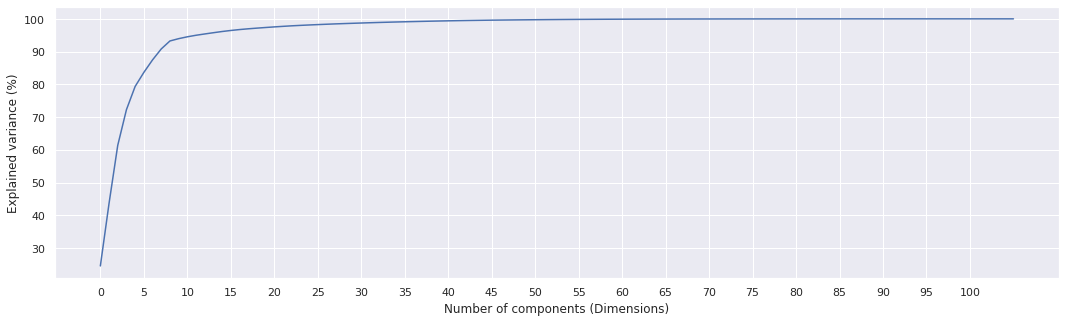

In [ ]:
# Apply PCA to training data
pca_base = PCA(n_components=None)
pca_base.fit(df_train_for_reg)

# Make scree plot
my_fcts.make_scree_plot(pca_base)

With 40 components basically the whole variance explained in the dataset can be explained. An elbow at around 8 components is visible which still explains around 93% of the variance. However, by trial-and-error I find that using 40 components gives the best results (marginally close to running on the full data but significantly less computation times). Therefore, the rest of the analysis is carried out using 40 components.

In [ ]:
# Instantiate PCA with 40 components
pca = PCA(n_components=40)

# Fit to training data
X_pca = pca.fit(df_train_for_reg)

# Transform train and test with the pipeline fittes on train data
X_pca_train, X_pca_test = pca.transform(df_train_for_reg), pca.transform(df_test_for_predict)

# pd.dataframes
X_pca_train, X_pca_test = pd.DataFrame(X_pca_train, index = df_train_for_reg.index), pd.DataFrame(X_pca_test, index = df_test_for_predict.index)

In [ ]:
X_pca_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
Index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-4.283328,-1.516495,0.085332,-0.451726,1.260310,1.003236,0.248930,1.693076,1.500348,0.337580,-0.141143,0.584934,-0.104851,0.691346,0.048417,0.039914,-0.148862,-0.142360,0.016151,-0.023085,-0.084900,-0.255612,-0.308966,0.037454,-0.046377,-0.166196,-0.015188,-0.304206,-0.061671,-0.026811,0.034882,0.076492,0.332183,-0.102411,0.090400,-0.048653,0.196815,-0.150916,0.037076,-0.327704
1,4.152504,-5.338704,-2.828650,2.433041,2.955373,1.141283,0.631321,0.577244,-0.660557,-0.100900,0.433920,-0.098831,-0.492903,-0.343292,0.551198,0.158969,-0.304813,0.454503,0.191933,-0.514874,0.064157,-0.197560,0.246534,0.226598,-0.184117,-0.183240,0.088459,0.001120,-0.157525,-0.459712,0.186807,0.558627,-0.513878,0.046392,-0.182703,-0.083208,-0.223374,-0.055976,-0.205013,-0.016704
2,-1.987575,0.387695,1.789003,-3.071947,0.045164,-0.526002,-2.152055,-1.247404,-0.862112,0.232419,0.035824,0.005556,0.070506,-0.488988,0.092329,0.063961,0.036670,-0.377267,0.126661,-0.510640,0.135228,0.382354,0.201017,0.305048,0.034781,0.177493,0.406613,0.147976,-0.045727,0.037722,0.121861,-0.286693,0.295655,0.071630,-0.623120,-0.097007,-0.074305,-0.450971,-0.028863,0.146885
3,-0.095748,-2.708777,2.742279,-0.901911,3.752742,0.837033,0.228913,-0.404415,0.162944,-0.021931,-0.493754,-0.460683,0.346473,-0.508235,-0.037798,-0.095394,-0.090240,-0.558911,-0.016213,0.495885,0.209650,-0.079929,-0.098917,0.085245,-0.160218,0.157332,-0.031366,0.122655,-0.007380,0.234148,-0.038574,0.006257,-0.017180,-0.100275,0.023119,0.119357,0.104772,-0.017078,0.002886,-0.004509
4,0.760135,-0.598386,-4.789016,-1.014466,1.821296,-0.510075,1.157286,-1.187145,1.278327,-0.368577,0.156721,-0.322859,0.333671,-0.190504,-0.487822,0.116006,0.340918,0.535189,-0.071251,-0.603794,0.008372,-0.009100,0.204812,-0.612079,0.230259,0.150023,-0.185733,0.283314,0.020912,0.274602,0.077628,-0.219248,0.036591,0.047373,-0.110457,-0.034044,-0.178085,0.030801,-0.170513,-0.060960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61001,-4.497353,0.596407,-0.945343,-1.334379,1.285675,1.319606,-0.746455,2.696933,1.913377,-0.063115,-0.341942,0.124965,0.473820,0.346448,0.928383,-0.063971,-0.191097,0.243989,0.145645,-0.224261,-0.609481,-0.320750,-0.090892,0.131007,0.195352,-0.247559,0.126366,-0.561268,0.146508,0.193192,0.229464,-0.067881,0.523443,-0.063256,0.084900,0.114724,0.032920,-0.274254,-0.007316,-0.199547
61002,2.921190,0.025878,2.533600,3.174846,-0.714674,-3.389546,0.657970,2.487251,-2.523983,-0.347911,-0.026841,0.270182,-0.509200,-0.047634,-0.183036,0.700860,0.270869,-0.182582,0.137472,0.087591,0.380592,-0.293384,0.061632,-0.265938,-0.243789,0.124432,0.248884,-0.084428,0.551056,0.109158,0.160971,0.261822,0.325988,0.227911,0.026393,-0.051874,0.037298,0.342139,-0.132318,-0.065332
61003,-1.667920,-1.401174,-1.162318,-0.614922,-1.228195,-0.961006,1.396114,1.370398,-1.179070,-0.229084,0.098767,0.341430,-0.259830,0.317222,-0.029380,-0.016690,0.093658,-0.263055,-0.121008,0.162331,0.182749,-0.264354,0.011035,-0.210361,-0.373138,0.236717,0.337329,-0.154876,0.566849,-0.114034,-0.154807,0.127609,0.049597,0.124917,0.083794,-0.102936,0.005197,0.039596,-0.004819,0.004716


# **3. Binary Logistic Model – Baseline**

## 3.1 Fit Model

In [ ]:
# To report stats
feature_names = df_train_for_reg.columns
class_labels = ['Not Krummholz', 'Krummholz']

In [ ]:
# Instantiate logistic regression
logit_base = LogisticRegression(penalty='none', 
                                C=100.0, 
                                fit_intercept=True, 
                                max_iter=5000)

# Fit
logit_base.fit(df_train_for_reg, target_bin) # Run time: 1m 13s

# Predict point estimates (for confusion matrix)
y_hat = logit_base.predict(df_train_for_reg)

# Predicted probabilities
p_hat = logit_base.predict_proba(df_train_for_reg)
p_hat = p_hat[:,1]
print(p_hat )

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[0.42 0.00 0.00 ... 0.00 0.00 0.00]


## 3.2 Feature Importance

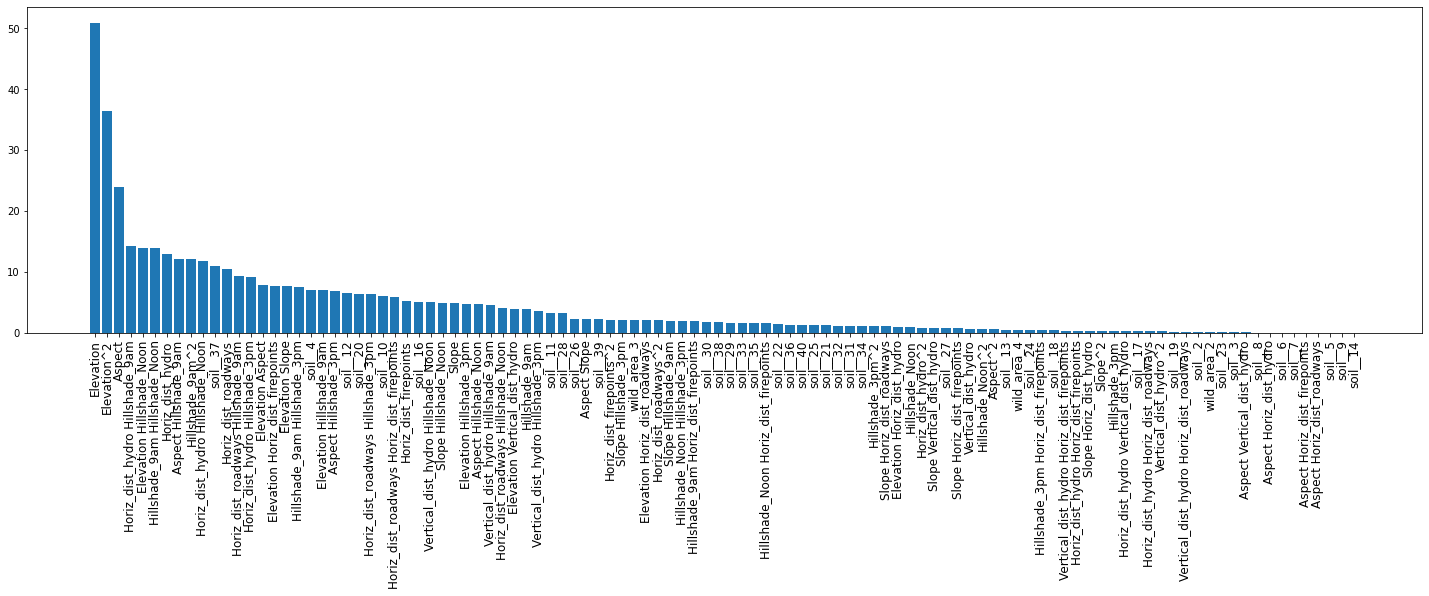

In [ ]:
my_fcts.make_feat_importance_plot(logit_base.coef_, feature_names)

## 3.3 Accuracy Assessment (in-sample)

In [ ]:
# AUC metric
fpr_base, tpr_base, thresholds_base = metrics.roc_curve(target_bin, p_hat)
roc_auc_base = metrics.auc(fpr_base, tpr_base)
print(roc_auc_base)

0.9859083083628767


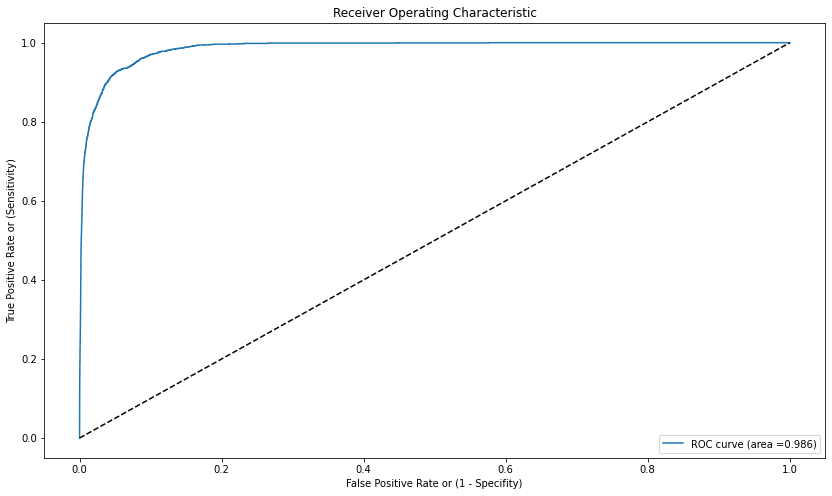

In [ ]:
my_fcts.make_roc_plot(fpr_base, tpr_base, roc_auc_base)

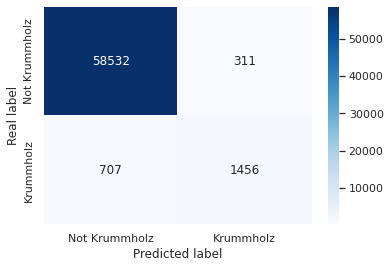

In [ ]:
# Plot confusion matrix
cm_base = confusion_matrix(y_pred=y_hat, y_true=target_bin, labels=[0,1] )

my_fcts.plot_confusion_matrix(cm_base, class_labels) 

## 3.4 Accuracy Assessment (out-of-sample)

In [ ]:
# Note to self: 'cvp' is alias for sklearn.model_selection.cross_val_predict

p_hat_cv_proba = cvp(logit_base, df_train_for_reg, target_bin, cv=5, method='predict_proba') #Runtime = 5m 44s
p_hat_cv_proba = p_hat_cv_proba[:,1]
print(p_hat_cv_proba)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Sett

[0.40 0.00 0.00 ... 0.00 0.00 0.00]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
# Cross-validated AUC metric
fpr_base_cv, tpr_base_cv, thresholds_base_cv = metrics.roc_curve(target_bin, p_hat_cv_proba)
roc_auc_base_cv = metrics.auc(fpr_base_cv, tpr_base_cv)
print(roc_auc_base_cv)

0.9843227716868435


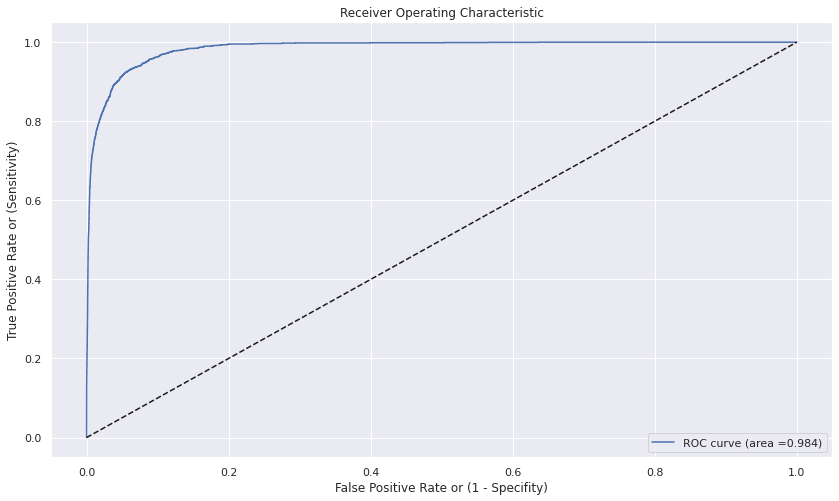

In [ ]:
my_fcts.make_roc_plot(fpr_base_cv, tpr_base_cv, roc_auc_base_cv)

So because the cross-validated AUC metric is high and close to the in-sample AUC, the model still seems to do well for out-of-sample classification.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Sett

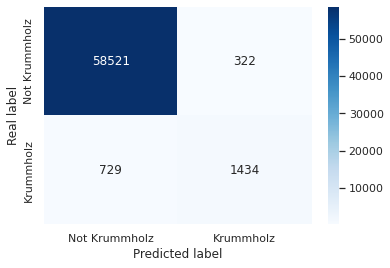

In [ ]:
# Plot confusion matrix
y_hat_cv_proba = cvp(logit_base, df_train_for_reg, target_bin, cv=5) #5m 33s

cm_base_cv = confusion_matrix(y_pred=y_hat_cv_proba, y_true=target_bin, labels=[0,1] )
my_fcts.plot_confusion_matrix(cm_base_cv, class_labels) 

# **4. Binary Logistic Model – Oversampled**

## 4.0 Oversample Data

I have also tried undersampling, and with various ways of preprocessing. I have tried various different methods of oversampling (`RandomOverSampler`, `class_weight = "balanced"`, `SMOTE`) and undersampling (`RandomUnderSampler`) and they all perform very similar. This is my preferred model. 

In [ ]:
#Apply SMOTE
smote = SMOTE(random_state = 101)
X_pca_oversample, y_pca_oversample = smote.fit_resample(X_pca_train, target_bin)

In [ ]:
X_pca_oversample

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,-4.283328,-1.516495,0.085332,-0.451726,1.260310,1.003236,0.248930,1.693076,1.500348,0.337580,-0.141143,0.584934,-0.104851,0.691346,0.048417,0.039914,-0.148862,-0.142360,0.016151,-0.023085,-0.084900,-0.255612,-0.308966,0.037454,-0.046377,-0.166196,-0.015188,-0.304206,-0.061671,-0.026811,0.034882,0.076492,0.332183,-0.102411,0.090400,-0.048653,0.196815,-0.150916,0.037076,-0.327704
1,4.152504,-5.338704,-2.828650,2.433041,2.955373,1.141283,0.631321,0.577244,-0.660557,-0.100900,0.433920,-0.098831,-0.492903,-0.343292,0.551198,0.158969,-0.304813,0.454503,0.191933,-0.514874,0.064157,-0.197560,0.246534,0.226598,-0.184117,-0.183240,0.088459,0.001120,-0.157525,-0.459712,0.186807,0.558627,-0.513878,0.046392,-0.182703,-0.083208,-0.223374,-0.055976,-0.205013,-0.016704
2,-1.987575,0.387695,1.789003,-3.071947,0.045164,-0.526002,-2.152055,-1.247404,-0.862112,0.232419,0.035824,0.005556,0.070506,-0.488988,0.092329,0.063961,0.036670,-0.377267,0.126661,-0.510640,0.135228,0.382354,0.201017,0.305048,0.034781,0.177493,0.406613,0.147976,-0.045727,0.037722,0.121861,-0.286693,0.295655,0.071630,-0.623120,-0.097007,-0.074305,-0.450971,-0.028863,0.146885
3,-0.095748,-2.708777,2.742279,-0.901911,3.752742,0.837033,0.228913,-0.404415,0.162944,-0.021931,-0.493754,-0.460683,0.346473,-0.508235,-0.037798,-0.095394,-0.090240,-0.558911,-0.016213,0.495885,0.209650,-0.079929,-0.098917,0.085245,-0.160218,0.157332,-0.031366,0.122655,-0.007380,0.234148,-0.038574,0.006257,-0.017180,-0.100275,0.023119,0.119357,0.104772,-0.017078,0.002886,-0.004509
4,0.760135,-0.598386,-4.789016,-1.014466,1.821296,-0.510075,1.157286,-1.187145,1.278327,-0.368577,0.156721,-0.322859,0.333671,-0.190504,-0.487822,0.116006,0.340918,0.535189,-0.071251,-0.603794,0.008372,-0.009100,0.204812,-0.612079,0.230259,0.150023,-0.185733,0.283314,0.020912,0.274602,0.077628,-0.219248,0.036591,0.047373,-0.110457,-0.034044,-0.178085,0.030801,-0.170513,-0.060960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117681,2.611654,3.948858,4.866259,-6.261879,0.565306,-1.567208,0.589333,0.625638,0.836282,1.148624,1.263943,-0.494456,0.068032,-1.355542,-0.276062,-1.347251,-1.386461,-0.013494,0.185491,-0.570029,-0.164188,0.011151,0.069606,0.103137,0.902431,0.126431,0.458039,-0.227399,0.084080,-0.049203,0.144810,0.164791,0.058402,0.040463,0.037903,0.068659,0.446787,-0.169933,0.270825,0.037283
117682,5.766429,-7.255503,-1.609533,3.486757,0.144149,-1.091326,0.789799,0.149378,1.754870,-0.254711,0.357965,-0.082336,-1.258574,0.582882,0.850628,-0.309316,-0.445830,-0.113903,-0.055323,-0.048679,-0.148972,-0.276438,0.305706,0.078159,0.341903,0.018676,-0.005827,0.032284,-0.095927,-0.321392,-0.031485,0.351685,0.281856,-0.123773,0.174022,-0.187354,0.212969,-0.103325,0.174077,-0.260164
117683,3.848525,-0.038149,-2.405940,-3.163781,-0.634399,-3.782684,-0.793980,-0.858070,1.981707,0.321204,-0.660887,0.229357,-0.270222,0.015143,-0.539644,-0.097467,0.007286,0.295985,0.199165,0.257704,-0.225449,-0.144999,-0.246747,0.276710,-0.030784,0.362784,0.001719,-0.224307,-0.269959,-0.003632,-0.199911,0.046165,0.289822,0.071360,0.120099,-0.041679,0.141960,-0.184628,0.025132,-0.424270
117684,-1.217669,3.048831,3.329114,-2.662253,0.181135,-1.918592,0.558056,0.850461,0.799495,-0.005681,0.057903,-0.418397,-0.672472,-0.189906,-0.007446,-0.316130,-0.314102,-0.278156,-0.291823,-0.217836,-0.033962,-0.245338,0.084893,0.087919,0.453857,0.107900,0.061807,0.006004,-0.238119,-0.123497,0.035075,0.053330,0.110177,-0.214159,-0.003425,0.021140,-0.016060,-0.018417,0.190573,-0.092618


## 4.1 Hyperparameter Optimization

In [ ]:
# Instantiate logistic reg, scaler and also PCA (to reduce dimensionality)
std_slc = StandardScaler()
log_reg = LogisticRegression(solver = 'liblinear', 
                             fit_intercept = True,)

# Create pipeline
pipe = Pipeline(steps=[('std_slc', std_slc), 
                       ('logistic_Reg', log_reg)
                       ])


# Creating Parameter Space
penalty = ['l1', 'l2']
C = np.logspace(-3, 3, 40)

parameters = dict(logistic_Reg__C=C, 
                  logistic_Reg__penalty=penalty)

In [ ]:
C

array([0.00, 0.00, 0.00, 0.00, 0.00, 0.01, 0.01, 0.01, 0.02, 0.02, 0.03,
       0.05, 0.07, 0.10, 0.14, 0.20, 0.29, 0.41, 0.59, 0.84, 1.19, 1.70,
       2.42, 3.46, 4.92, 7.02, 10.00, 14.25, 20.31, 28.94, 41.25, 58.78,
       83.77, 119.38, 170.13, 242.45, 345.51, 492.39, 701.70, 1000.00])

In [ ]:
# No. of cores in Colab:
import multiprocessing
n_cpus = multiprocessing.cpu_count()
n_cpus

2

In [ ]:
clf = GridSearchCV(pipe, parameters, n_jobs = n_cpus, scoring = 'roc_auc', cv = 5, verbose = 2)

# Fitting the grid search
clf.fit(X_pca_oversample, y_pca_oversample) #Run time: 5m 51s

# Viewing The Best Parameters
best_C = clf.best_estimator_.get_params()['logistic_Reg__C']
best_pen = clf.best_estimator_.get_params()['logistic_Reg__penalty']

print('Best Penalty:', best_pen)
print('Best C:', best_C)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best Penalty: l2
Best C: 83.76776400682924


## 4.2 Fit Model

In [ ]:
best_C, best_pen

(83.76776400682924, 'l2')

In [ ]:
#Instantiate logistic regression on resampled data

logit_opt = LogisticRegression(fit_intercept = True,
                               #C=best_C, 
                               C = 83.76776400682924,
                               #penalty= best_pen, 
                               penalty = 'l2',
                               solver='liblinear')

# Fit
logit_opt.fit(X_pca_oversample, y_pca_oversample) 

# Predict classes
p_hat_opt = logit_opt.predict(X_pca_train)

#Predicted probabilities
p_hat_opt_proba = logit_opt.predict_proba(X_pca_train)
p_hat_opt_proba = p_hat_opt_proba[:,1]
print(p_hat_opt_proba)

[0.95 0.00 0.00 ... 0.00 0.00 0.01]


In [ ]:
# Set correct weights for correction function
target_bin = np.array(target_bin)
y_pca_oversample = np.array(y_pca_oversample)

# Ratio of 1s in original target
q1 = target_bin.sum()/len(target_bin)

# Ratio of 1s in resampled target
r1 = y_pca_oversample.sum()/len(y_pca_oversample)

In [ ]:
# correcting ''imb'' predictions for biased sample
p_hat_opt_proba = pd.Series(p_hat_opt_proba)
p_hat_opt_proba_corr = p_hat_opt_proba.apply(my_fcts.reweight,args=(q1,r1))
p_hat_opt_proba_corr

0        4.125849e-01
1        1.813447e-04
2        1.086548e-07
3        1.692985e-04
4        1.524027e-04
             ...     
61001    4.734543e-01
61002    1.628661e-03
61003    6.618189e-05
61004    8.678214e-07
61005    1.996685e-04
Length: 61006, dtype: float64

## 4.3 Feature Importance

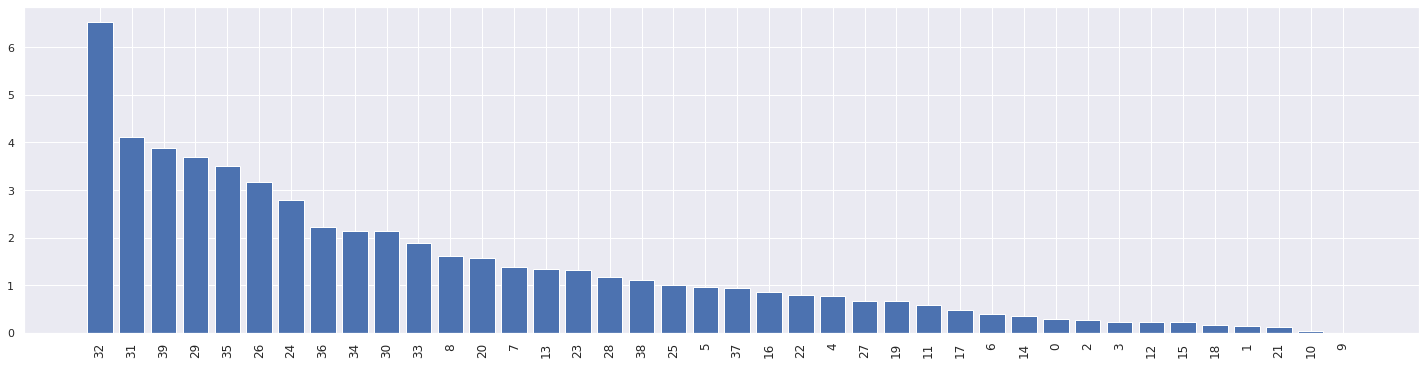

In [ ]:
feature_names = X_pca_train.columns.astype(str)
my_fcts.make_feat_importance_plot(logit_opt.coef_, feature_names)

## 4.4 Accuracy Assessment (in-sample)

In [ ]:
# AUC metric
fpr_opt, tpr_opt, thresholds_opt = metrics.roc_curve(target_bin, p_hat_opt_proba_corr)
roc_auc_opt = metrics.auc(fpr_opt, tpr_opt)
print(roc_auc_opt)

0.9806832569949628


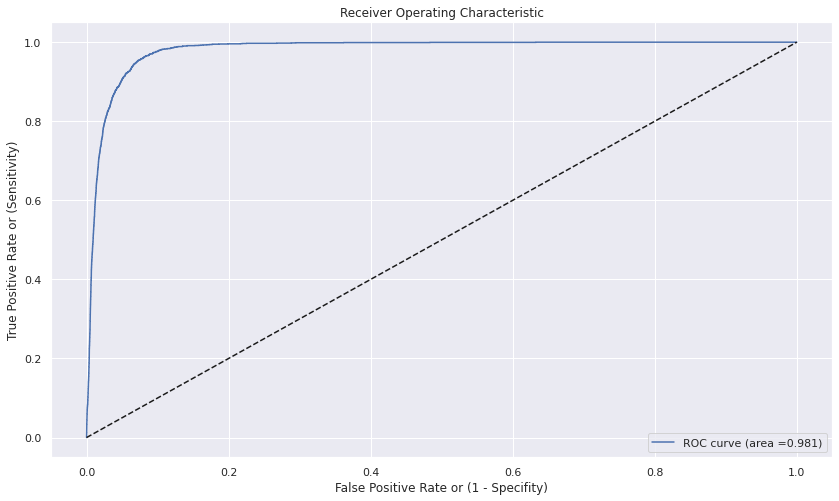

In [ ]:
my_fcts.make_roc_plot(fpr_opt, tpr_opt, roc_auc_opt)

## 4.5 Accuracy Assessment (out-of-sample)

In [ ]:
# Note to self: 'cvp' is alias for sklearn.model_selection.cross_val_predict
p_hat_opt_cv_proba = cvp(logit_opt, X_pca_train, target_bin, cv=50, method='predict_proba') #Runtime = 1m 44s
p_hat_opt_cv_proba = p_hat_opt_cv_proba[:,1]
p_hat_opt_cv_proba

# Reweight predictions
p_hat_opt_cv_proba = pd.Series(p_hat_opt_cv_proba)
p_hat_opt_cv_proba_corr = p_hat_opt_cv_proba.apply(my_fcts.reweight,args=(q1,r1))
p_hat_opt_cv_proba_corr

0        2.711753e-02
1        1.053755e-05
2        1.623594e-09
3        2.560424e-05
4        6.111787e-06
             ...     
61001    1.776120e-02
61002    1.587214e-04
61003    1.305882e-05
61004    6.100637e-07
61005    1.128145e-05
Length: 61006, dtype: float64

In [ ]:
# AUC metric
fpr_cv_opt, tpr_cv_opt, thresholds_cv_opt = metrics.roc_curve(target_bin, p_hat_opt_cv_proba_corr)
roc_auc_cv_opt = metrics.auc(fpr_cv_opt, tpr_cv_opt)
print(roc_auc_cv_opt)

0.9786958579585793


So because the cross-validated AUC metric is high and close to the in-sample AUC, the model still seems to do well for out-of-sample classification.

# **5. Multiclass Logistic Model – Class Imbalance**

This time I will go straigt for prediction with class imbalance, and then compare it to a baseline model afterwards.

## 5.1 Fit Multiclass Model and Reweight Predictions

Fit model:

In [ ]:
#Instantiate and fit
logit_multi_imb = LogisticRegression(penalty='l2', 
                                     #penalty = best_pen_multi
                                     #C = best_C_multi,
                                     C=100,
                                     fit_intercept=True,
                                     class_weight= 'balanced',
                                     multi_class = 'multinomial',
                                     solver= 'lbfgs', #<- 'liblinear' not allowed for multiclass
                                     max_iter=5000)

logit_multi_imb.fit(X_pca_train, target_multi) # Run time: 3m 41s


# Predict probabilities on train data
p_hat_multi = logit_multi_imb.predict_proba(X_pca_train)

# Reweight and point predict
r, q = 1/7, list(target_multi.value_counts()/target_multi.count())

p_hat_multi_rw = my_fcts.reweight_proba_multi(p_hat_multi, q, r)
y_hat_multi_rw = my_fcts.make_multi_point_pred(p_hat_multi_rw)

In [ ]:
print(target_multi.value_counts())
print(y_hat_multi_rw.value_counts())

2    29690
1    22199
3     3802
7     2163
6     1865
5      992
4      295
Name: Cover_Type, dtype: int64
1    28956
2    24553
3     5126
4      833
6      628
5      594
7      316
dtype: int64


## 5.2 Accuracy Assessment (in-sample)

Confusion Matrix:

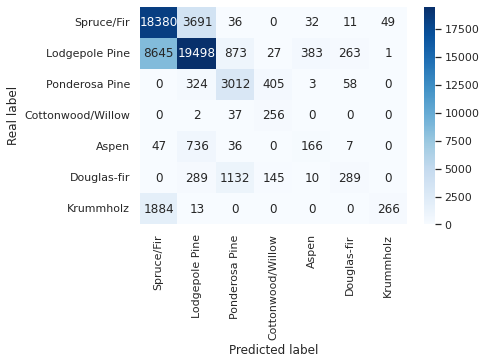

In [ ]:
cm_multi_imb =  confusion_matrix(y_pred=y_hat_multi_rw, 
                             y_true=target_multi, 
                             labels=[1,2,3,4,5,6,7])

class_labels_multi = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']
my_fcts.plot_confusion_matrix(cm_multi_imb, class_labels_multi)

So the model does not seem to predict multiclasses particularly well. The majority of `Krummholz` were falsly predicted as `Spruce`. `Cottonwood/Willow`, `Aspen`, `Douglas-fir` are not well predicted. However, `Spruce/Fir`, `Lodgepole Pine`, `Ponderosa Pine` are predicted reasonably well. It would have been preferable to investigate further the inprecise classifications of `Krummholz`, `Cottonwood/Willow`, `Aspen`, `Douglas-fir`, however, time did not permit this.

Classification report:

In [ ]:
# Classification Report
print(classification_report(y_true = target_multi, y_pred = y_hat_multi_rw))

              precision    recall  f1-score   support

           1       0.63      0.83      0.72     22199
           2       0.79      0.66      0.72     29690
           3       0.59      0.79      0.67      3802
           4       0.31      0.87      0.45       295
           5       0.28      0.17      0.21       992
           6       0.46      0.15      0.23      1865
           7       0.84      0.12      0.21      2163

    accuracy                           0.69     61006
   macro avg       0.56      0.51      0.46     61006
weighted avg       0.70      0.69      0.67     61006



## 5.3 Accuracy (Out-of-sample)

In [ ]:
# Cross-validation
p_hat_mult_cv_proba = cvp(logit_multi_imb, X_pca_train, target_multi, cv=5, method='predict_proba') #Runtime: 11m
p_hat_mult_cv_proba


# Reweight and point predict
r, q = 1/7, list(target_multi.value_counts()/target_multi.count())

p_hat_mult_cv_rw = my_fcts.reweight_proba_multi(p_hat_mult_cv_proba, q, r)
y_hat_mult_cv_rw = my_fcts.make_multi_point_pred(p_hat_mult_cv_rw)

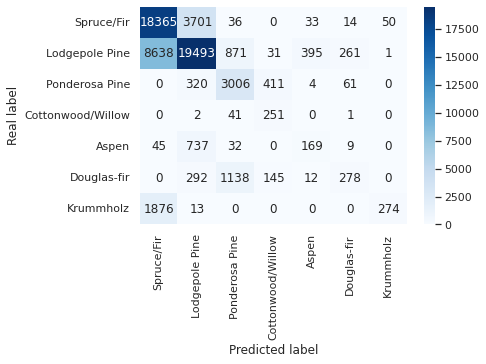

In [ ]:
#Confusion Matrix
cm_multi_cv =  confusion_matrix(y_pred=y_hat_mult_cv_rw, 
                             y_true=target_multi, 
                             labels=[1,2,3,4,5,6,7])

my_fcts.plot_confusion_matrix(cm_multi_cv, class_labels_multi)

In [ ]:
# Classification Report
print(classification_report(y_true = target_multi, y_pred = y_hat_mult_cv_rw))

              precision    recall  f1-score   support

           1       0.63      0.83      0.72     22199
           2       0.79      0.66      0.72     29690
           3       0.59      0.79      0.67      3802
           4       0.30      0.85      0.44       295
           5       0.28      0.17      0.21       992
           6       0.45      0.15      0.22      1865
           7       0.84      0.13      0.22      2163

    accuracy                           0.69     61006
   macro avg       0.55      0.51      0.46     61006
weighted avg       0.70      0.69      0.67     61006



## 5.4 Comparison to Naïve Multiclass Model

In [ ]:
#Instantiate and fit
logit_multi_naive = LogisticRegression(penalty='l2', C=100, 
                           fit_intercept=True, 
                           #class_weight= 'balanced',
                           multi_class = 'multinomial',
                           solver= 'lbfgs', #<- 'liblinear' not allowed for multiclass
                           max_iter=5000)


logit_multi_naive.fit(X_pca_train, target_multi) 

#Point predict
y_hat_naive = logit_multi_naive.predict(X_pca_train)

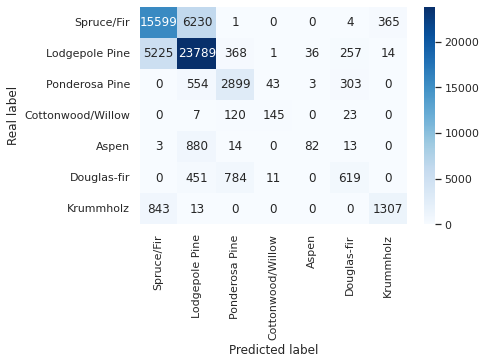

In [ ]:
cm_multi_naive =  confusion_matrix(y_pred=y_hat_naive, 
                             y_true=target_multi, 
                             labels=[1,2,3,4,5,6,7])

class_labels_multi = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']
my_fcts.plot_confusion_matrix(cm_multi_naive, class_labels_multi)

Curiously, this naïve model seems to do equally as well if not better than the model which deals with imbalance (it also scores higher on Kaggle). The naïve model is better at predicting `Lodgepole Pine`, `Douglas-fir` and much better at predicting `Krummholz`. However, it is worse at predicting ``Spruce`` and `Ponderosa Pine`.

In [ ]:
# Classification Report
print(classification_report(y_true = target_multi, y_pred = y_hat_naive))

              precision    recall  f1-score   support

           1       0.72      0.70      0.71     22199
           2       0.75      0.80      0.77     29690
           3       0.69      0.76      0.73      3802
           4       0.72      0.49      0.59       295
           5       0.68      0.08      0.15       992
           6       0.51      0.33      0.40      1865
           7       0.78      0.60      0.68      2163

    accuracy                           0.73     61006
   macro avg       0.69      0.54      0.57     61006
weighted avg       0.73      0.73      0.72     61006



# _Export Binary Predictions for Kaggle Competition

Link to Binary Kaggle Competition: [https://www.kaggle.com/c/bgse-lc-forest/leaderboard](https://www.kaggle.com/c/bgse-lc-forest/leaderboard).

In [ ]:
# Dataframe for submission w. imb. predictions
p_hat_test_kaggle = logit_opt.predict_proba(X_pca_test)
p_hat_test_kaggle = p_hat_test_kaggle[:,1]

kaggle = pd.DataFrame(p_hat_test_kaggle, index = df_test_for_predict.index).rename(columns={0: "p_hat_test_kaggle"})


# Reweight dataframe w. imb. predictions
q1 = target_bin.sum()/len(target_bin)
r1 = y_pca_oversample.sum()/len(y_pca_oversample)

kaggle["p_hat_test_kaggle"] = kaggle["p_hat_test_kaggle"].apply(my_fcts.reweight,args=(q1,r1))
kaggle

,p_hat_test_kaggle
Index,
61006,1.963090e-03
61007,1.007816e-03
61008,2.751762e-01
61009,6.032335e-09
61010,1.897928e-05
...,...
74074,1.295304e-04
74075,1.097955e-04
74076,1.902035e-07


In [ ]:
# Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"Index": kaggle.index, "Cover_Type": kaggle['p_hat_test_kaggle']})
test_predictions_submit.to_csv("Predictions/pred13_pca_smote_opt-hyp-c170-l2.csv", index = False)

# _Export Multiclass Predictions for Kaggle Competition

Link to Multiclass Kaggle Competition: [https://www.kaggle.com/c/bgse-lc-forest-multi/leaderboard](https://www.kaggle.com/c/bgse-lc-forest-multi/leaderboard).

In [ ]:
# Predict probabilities on test data
p_hat_multi = logit_multi_imb.predict_proba(df_test_scl)

# Reweight and point predict
p_hat_multi_rw = my_fcts.reweight_proba_multi(p_hat_multi, q, r)
y_hat_multi_rw = my_fcts.make_multi_point_pred(p_hat_multi_rw)
y_hat_multi_rw

# Make Dataframe for Kaggle submission
kaggle_multi = pd.DataFrame(y_hat_multi_rw).set_index(df_test_scl.index).rename(columns={0: "y_hat_multi_rw"})
kaggle_multi

,y_hat_multi_rw
Index,
61006,1
61007,2
61008,1
61009,2
61010,2
...,...
74074,1
74075,2
74076,2


In [ ]:
test_multiclass_predictions_submit = pd.DataFrame({"Index": kaggle_multi.index, "Cover_Type": kaggle_multi['y_hat_multi_rw']})
test_multiclass_predictions_submit.to_csv("Predictions/Multi/pred8_imb-rw_no-soil-dumm.csv", index = False)